In [1]:
import matplotlib.pyplot as plt
import aplpy
import numpy as np
#matplotlib.rc("font", size=18)
import soxs
import astropy.units as u
from astropy.coordinates import SkyCoord
import subprocess #for running scripts
import os


soxs : [WARNING  ] 2023-05-16 23:23:56,045 Setting 'soxs_data_dir' to /Users/ryan/Library/Caches/soxs for this session. Please update your configuration if you want it somewhere else.


In [2]:
nhtor = [22,23,24] # torus column density
#nhlos = [1.e+22,1.e+23,1.e+24] # los of sight column density
z = 0.05 # redshifts
view_angle = 70
open_angle = np.degrees(np.arccos(0.85)) # here we're choosing a covering factor of 85%
#np.cos(np.radians(60))
#np.degrees(np.arccos(0.85))

In [3]:
# Here we are establishing the models for the borus models
def model_borus(z,angle,emin,emax,norm):
    model = "tbabs*(atable{/Users/ryan/Dropbox/GitHub/SOXS/LEM/borus02_v170323c.fits}+ztbabs*cabs*zcutoffpl+const*zcutoffpl+apec+apec)" # A somewhat complicated model
    galnh = 1.0e-2
    emin = emin
    emax = emax
    nbins = 20000
    theta=angle
    flux = norm # erg/s/cm**2
    borus1 = []
    nh_tab1 = []
    borus2 = []
    nh_tab2 = []
    for nh1 in nhtor:
        for nh2 in nhtor:
            params = [galnh,1.8,300,nh1,open_angle,theta,1.0,z,1.0e-3,((10**nh1)/(1.e+22)),z,((10**nh1)/(1.e+22)),1.8,300,z,1.e-3,0.005,1.8,300,z,1.e-3,0.1,1.0,z,1.e-3,0.90,1.0,z,1.e-3]    
            # For the 1st AGN
            spec1 = soxs.spectra.Spectrum.from_xspec_model(model, params, emin, emax, nbins)
            spec1.rescale_flux(1.e-13, emin=(2/(z+1)), emax=(10/(z+1)), flux_type="energy")
            borus1.append(spec1)
            nh_tab1.append(nh1)
            # For the 2nd AGN now:
            params = [galnh,1.8,300,nh2,60,theta,1.0,z,1.0e-3,((10**nh2)/(1.e+22)),z,((10**nh2)/(1.e+22)),1.8,300,z,1.e-3,0.005,1.8,300,z,1.e-3,0.3,1.0,z,1.e-3,0.65,1.0,z,1.e-3]    
            spec2 = soxs.spectra.Spectrum.from_xspec_model(model, params, emin, emax, nbins)
            spec2.rescale_flux(flux, emin=(2/(z+1)), emax=(10/(z+1)), flux_type="energy")
            borus2.append(spec2)
            nh_tab2.append(nh2)
    return borus1, nh_tab1, borus2, nh_tab2

# FLUXES OF 1.E-14 ARE TOO DIM!

In [4]:
borus1, nh_tab1, borus2, nh_tab2, = model_borus(z,view_angle,0.1,100.0,5.e-14)


In [1]:
#borus1[2]

In [5]:
from soxs import PointSourceModel
from soxs import write_spectrum
from soxs import plot_spectrum

# Center of the field of view
ra0 = 30.0 # degrees
dec0 = 45.0 # degrees

# Create a list of RA and Dec offsets that we'll load into a function to generate a series of point sources \
# at varying separations
c0 = SkyCoord(ra0*u.deg, dec0*u.deg, frame='icrs')
c1 = SkyCoord(ra0*u.deg, dec0*u.deg, frame='icrs') 

sep=['50','40','30','20','18','16','15','14','12','10','8','6','5','4','2','0']
ras1 = [c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra]
decs1 = [c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec]

ras2 = []
decs2 = []
for i in sep:
    c2 = c0.directional_offset_by(90 * u.deg, int(i) * u.arcsec) 
    ras2.append(c2.ra)
    decs2.append(c2.dec)

#print(ras2)
#print(decs2)

In [6]:
os.getcwd()
#os.chdir('../')

'/Users/ryan/Dropbox/GitHub/SOXS/HEXP'

In [8]:
def sim_duals(ras1, decs1, ras2, decs2, sep, exp, borus1, nh_tab1, borus2, nh_tab2):
    for i,j,x,y,k in zip(ras1,decs1,ras2,decs2,sep):
        # Making directory for the particular separation in question
        if not os.path.exists('Sep_'+str(k)+'as/'):
            os.mkdir('Sep_'+str(k)+'as/')
        os.chdir('Sep_'+str(k)+'as/')
        print('Now working in directory: ' + os.getcwd())
        #Now creating the spatial models
        pt_src1 = PointSourceModel(i, j) # AGN1
        pt_src2 = PointSourceModel(x, y) # AGN2
        ###### Now generating source region apertures for the sources
        rad=10
        str1 = 'circle('+str(i/u.deg)+','+str(j/u.deg)+','+str(rad)+'''\"'''+')' #+'''\\''' + '\"' 
        str2 = 'circle('+str(x/u.deg)+','+str(y/u.deg)+','+str(rad)+'''\"'''+')' #+'''\\''' + '\"' 
        with open("cir1_"+str(k)+".reg", 'w') as reg1:
            reg1.write('# Region file format: DS9 version 4.1 \n')
            reg1.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            reg1.write('fk5 \n')
            reg1.write(str1) 
        with open("cir2_"+str(k)+".reg", 'w') as reg2:
            reg2.write('# Region file format: DS9 version 4.1 \n')
            reg2.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            reg2.write('fk5 \n')
            reg2.write(str2) 
        ##### Now generating a background region that we will compare to
        str3 = 'circle('+str(29.9916000)+','+str(45.0483000)+','+str(60)+'''\"'''+')' #+'''\\''' + '\"'
        with open("bkg_"+str(k)+".reg", 'w') as reg3:
            reg3.write('# Region file format: DS9 version 4.1 \n')
            reg3.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            reg3.write('fk5 \n')
            reg3.write(str3) 
        # Now adding a loop to generate simputs for the different combos of AGN1 and AGN2
        for spec1,spec2,nh1,nh2 in zip(borus1, borus2, nh_tab1, nh_tab2):
            # Generating the simput photon distributions convolved with a spatial model
            sou1_phlist = soxs.SimputPhotonList.from_models("AGN 1", spec1, pt_src1, (500.0, "ks"), (3.0, "m**2"))
            sou2_phlist = soxs.SimputPhotonList.from_models("AGN 2", spec2, pt_src2, (500.0, "ks"), (3.0, "m**2"))
            # Create the SIMPUT catalog "sim_cat" from the photon lists "AGN1" and "AGN2"
            NHflag="_NH1_"+str(nh1)+"_NH2_"+str(nh2)
            sim_cat = soxs.SimputCatalog.from_source("dualagn_"+str(k)+"as_simput"+str(NHflag)+".fits", sou1_phlist, overwrite=True)
            sim_cat.append(sou2_phlist)
            # Here we are interfacing with SIXTE with a bash script to generate event files, science images, and spectra
            #%run sixte_duals_simulations.sh sep ras1 decs1 exp # Running the sixte simulations now
            sim = subprocess.run('/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh '+ str(k) + ' ' + str(i/u.deg) + ' ' + str(j/u.deg) + ' ' + str(exp) + ' ' + str(NHflag), shell=True)
            print(sim)
            # This takes in arguments for the separation, ra1 and dec1, and the exposure time choice
            # These are needed for naming conventions, assignment of the observation pointing, and the exposure time
        os.chdir('../')


In [11]:
(10**2)/(60**2)


0.027777777777777776

In [12]:
(60**2)/(10**2)

36.0

In [9]:
#os.chdir('HEXP/')
os.getcwd()

'/Users/ryan/Dropbox/GitHub/SOXS/HEXP'

In [10]:
if not os.path.exists('Borus/'):
    os.mkdir('Borus/')
os.chdir('Borus/')

sim_duals(ras1, decs1, ras2, decs2, sep, 50000, borus1, nh_tab1, borus2, nh_tab2)

os.chdir('../')


soxs : [INFO     ] 2023-05-13 15:04:09,891 Creating 2645095 energies from this spectrum.


Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_50as


soxs : [INFO     ] 2023-05-13 15:04:10,220 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:04:10,460 Creating 1534292 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:04:10,620 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:04:10,821 Appending source 'AGN 1' to dualagn_50as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 15:04:11,579 Appending source 'AGN 2' to dualagn_50as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 15:06:41,986 Creating 2645665 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 50 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 15:06:42,284 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:06:42,467 Creating 2407982 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:06:42,732 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:06:42,935 Appending source 'AGN 1' to dualagn_50as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 15:06:43,579 Appending source 'AGN 2' to dualagn_50as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 15:09:59,110 Creating 2648714 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 50 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 15:09:59,474 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:09:59,707 Creating 15488297 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:10:01,902 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:10:03,226 Appending source 'AGN 1' to dualagn_50as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 15:10:04,430 Appending source 'AGN 2' to dualagn_50as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 15:12:45,270 Creating 3956129 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 50 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 15:12:45,740 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:12:46,049 Creating 1533757 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:12:46,236 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:12:46,505 Appending source 'AGN 1' to dualagn_50as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 15:12:47,327 Appending source 'AGN 2' to dualagn_50as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 15:15:23,176 Creating 3960400 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 50 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 15:15:23,629 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:15:23,907 Creating 2409676 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:15:24,159 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:15:24,401 Appending source 'AGN 1' to dualagn_50as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 15:15:25,143 Appending source 'AGN 2' to dualagn_50as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 15:17:56,075 Creating 3958474 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 50 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 15:17:56,522 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:17:56,792 Creating 15483887 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:17:58,629 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:17:59,555 Appending source 'AGN 1' to dualagn_50as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 15:18:00,630 Appending source 'AGN 2' to dualagn_50as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 15:20:36,827 Creating 19461809 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 50 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 15:20:39,248 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:20:40,502 Creating 1533954 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:20:40,667 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:20:41,222 Appending source 'AGN 1' to dualagn_50as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 15:20:44,551 Appending source 'AGN 2' to dualagn_50as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 15:23:19,968 Creating 19465707 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:23:22,349 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:23:23,635 Creating 2408877 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:23:23,908 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:23:24,455 Appending source 'AGN 1' to dualagn_50as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 15:23:27,951 Appending source 'AGN 2' to dualagn_50as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 15:26:10,312 Creating 19463943 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 50 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 15:26:12,707 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:26:14,244 Creating 15479928 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:26:16,094 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:26:17,321 Appending source 'AGN 1' to dualagn_50as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 15:26:20,947 Appending source 'AGN 2' to dualagn_50as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 15:29:04,573 Creating 2648194 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 50 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_40as


soxs : [INFO     ] 2023-05-13 15:29:04,866 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:29:05,059 Creating 1534686 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:29:05,223 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:29:05,407 Appending source 'AGN 1' to dualagn_40as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 15:29:05,931 Appending source 'AGN 2' to dualagn_40as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 15:31:34,178 Creating 2644581 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 40 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 15:31:34,477 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:31:34,633 Creating 2410174 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:31:34,898 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:31:35,079 Appending source 'AGN 1' to dualagn_40as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 15:31:35,661 Appending source 'AGN 2' to dualagn_40as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 15:34:05,405 Creating 2645686 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 40 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 15:34:05,705 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:34:05,867 Creating 15492684 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:34:07,726 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:34:08,667 Appending source 'AGN 1' to dualagn_40as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 15:34:09,518 Appending source 'AGN 2' to dualagn_40as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 15:36:44,852 Creating 3958585 energies from this spectrum.


CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 40 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 15:36:45,312 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:36:45,560 Creating 1531858 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:36:45,724 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:36:45,967 Appending source 'AGN 1' to dualagn_40as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 15:36:46,801 Appending source 'AGN 2' to dualagn_40as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 15:39:16,936 Creating 3958033 energies from this spectrum.


CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 40 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 15:39:17,385 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:39:17,634 Creating 2408610 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:39:17,888 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:39:18,136 Appending source 'AGN 1' to dualagn_40as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 15:39:18,966 Appending source 'AGN 2' to dualagn_40as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 15:41:49,640 Creating 3961119 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 40 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 15:41:50,094 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:41:50,350 Creating 15484332 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:41:52,177 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:41:53,206 Appending source 'AGN 1' to dualagn_40as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 15:41:54,407 Appending source 'AGN 2' to dualagn_40as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 15:44:30,384 Creating 19464204 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 40 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 15:44:32,762 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:44:34,163 Creating 1532312 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:44:34,331 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:44:34,894 Appending source 'AGN 1' to dualagn_40as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 15:44:38,523 Appending source 'AGN 2' to dualagn_40as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 15:47:14,414 Creating 19465545 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 40 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 15:47:16,763 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:47:18,180 Creating 2409717 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:47:18,450 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:47:18,984 Appending source 'AGN 1' to dualagn_40as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 15:47:22,796 Appending source 'AGN 2' to dualagn_40as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 15:49:58,257 Creating 19462225 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 40 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 15:50:00,664 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:50:02,127 Creating 15486988 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:50:03,992 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:50:05,187 Appending source 'AGN 1' to dualagn_40as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 15:50:09,185 Appending source 'AGN 2' to dualagn_40as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

soxs : [INFO     ] 2023-05-13 15:52:51,528 Creating 2647770 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 40 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_30as


soxs : [INFO     ] 2023-05-13 15:52:51,825 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:52:52,018 Creating 1534115 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:52:52,179 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:52:52,361 Appending source 'AGN 1' to dualagn_30as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 15:52:52,931 Appending source 'AGN 2' to dualagn_30as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 15:55:27,426 Creating 2644748 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 30 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 15:55:27,752 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:55:27,965 Creating 2408511 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:55:28,246 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:55:28,492 Appending source 'AGN 1' to dualagn_30as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 15:55:29,231 Appending source 'AGN 2' to dualagn_30as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 15:58:01,660 Creating 2645451 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 30 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 15:58:01,961 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:58:02,124 Creating 15493075 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 15:58:04,028 Finished creating energies.
soxs : [INFO     ] 2023-05-13 15:58:05,064 Appending source 'AGN 1' to dualagn_30as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 15:58:05,901 Appending source 'AGN 2' to dualagn_30as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:00:41,654 Creating 3957934 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 30 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 16:00:42,112 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:00:42,366 Creating 1532256 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:00:42,525 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:00:42,768 Appending source 'AGN 1' to dualagn_30as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 16:00:43,623 Appending source 'AGN 2' to dualagn_30as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 16:03:16,586 Creating 3958595 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 30 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 16:03:17,039 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:03:17,295 Creating 2411232 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:03:17,550 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:03:17,792 Appending source 'AGN 1' to dualagn_30as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 16:03:18,682 Appending source 'AGN 2' to dualagn_30as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:05:48,758 Creating 3961518 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 30 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 16:05:49,215 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:05:49,470 Creating 15478214 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:05:51,277 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:05:52,222 Appending source 'AGN 1' to dualagn_30as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 16:05:53,327 Appending source 'AGN 2' to dualagn_30as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:08:29,404 Creating 19465232 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 30 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 16:08:31,799 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:08:33,156 Creating 1532351 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:08:33,330 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:08:33,908 Appending source 'AGN 1' to dualagn_30as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 16:08:37,754 Appending source 'AGN 2' to dualagn_30as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:11:13,238 Creating 19466107 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 30 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 16:11:15,630 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:11:17,008 Creating 2409974 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:11:17,287 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:11:17,829 Appending source 'AGN 1' to dualagn_30as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 16:11:21,479 Appending source 'AGN 2' to dualagn_30as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 16:13:56,642 Creating 19464525 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 30 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 16:13:59,033 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:14:00,412 Creating 15485941 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:14:02,302 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:14:03,546 Appending source 'AGN 1' to dualagn_30as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 16:14:07,442 Appending source 'AGN 2' to dualagn_30as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:16:52,108 Creating 2649191 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 30 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_20as


soxs : [INFO     ] 2023-05-13 16:16:52,440 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:16:52,684 Creating 1534324 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:16:52,856 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:16:53,087 Appending source 'AGN 1' to dualagn_20as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 16:16:53,685 Appending source 'AGN 2' to dualagn_20as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:19:31,136 Creating 2645610 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 20 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 16:19:31,445 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:19:31,658 Creating 2408729 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:19:31,933 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:19:32,160 Appending source 'AGN 1' to dualagn_20as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 16:19:32,796 Appending source 'AGN 2' to dualagn_20as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:22:09,848 Creating 2648262 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 20 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 16:22:10,160 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:22:10,368 Creating 15487583 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:22:12,354 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:22:13,555 Appending source 'AGN 1' to dualagn_20as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 16:22:14,615 Appending source 'AGN 2' to dualagn_20as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:24:55,222 Creating 3959776 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 20 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 16:24:55,690 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:24:55,979 Creating 1535117 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:24:56,136 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:24:56,418 Appending source 'AGN 1' to dualagn_20as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 16:24:57,347 Appending source 'AGN 2' to dualagn_20as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:27:33,057 Creating 3961143 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 20 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 16:27:33,538 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:27:33,866 Creating 2410814 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:27:34,129 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:27:34,436 Appending source 'AGN 1' to dualagn_20as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 16:27:35,421 Appending source 'AGN 2' to dualagn_20as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:30:16,646 Creating 3954697 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 20 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 16:30:17,163 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:30:17,533 Creating 15489982 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:30:19,697 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:30:21,828 Appending source 'AGN 1' to dualagn_20as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 16:30:23,737 Appending source 'AGN 2' to dualagn_20as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:33:13,192 Creating 19464150 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 20 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 16:33:15,696 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:33:17,317 Creating 1533565 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:33:17,493 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:33:18,221 Appending source 'AGN 1' to dualagn_20as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 16:33:22,503 Appending source 'AGN 2' to dualagn_20as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:36:07,660 Creating 19460108 energies from this spectrum.


CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 20 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)
initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate

soxs : [INFO     ] 2023-05-13 16:36:10,159 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:36:11,890 Creating 2411595 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:36:12,168 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:36:12,888 Appending source 'AGN 1' to dualagn_20as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 16:36:16,771 Appending source 'AGN 2' to dualagn_20as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:38:58,503 Creating 19462036 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 20 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 16:39:01,012 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:39:02,668 Creating 15484227 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:39:04,594 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:39:06,076 Appending source 'AGN 1' to dualagn_20as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 16:39:10,470 Appending source 'AGN 2' to dualagn_20as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:41:58,058 Creating 2647598 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 20 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_18as


soxs : [INFO     ] 2023-05-13 16:41:58,366 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:41:58,588 Creating 1532976 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:41:58,748 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:41:58,952 Appending source 'AGN 1' to dualagn_18as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 16:41:59,624 Appending source 'AGN 2' to dualagn_18as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 16:44:32,639 Creating 2648154 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 18 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 16:44:32,933 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:44:33,111 Creating 2407986 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:44:33,367 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:44:33,568 Appending source 'AGN 1' to dualagn_18as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 16:44:34,230 Appending source 'AGN 2' to dualagn_18as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 16:47:03,167 Creating 2647127 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 18 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 16:47:03,471 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:47:03,684 Creating 15487264 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:47:05,572 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:47:06,513 Appending source 'AGN 1' to dualagn_18as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 16:47:07,549 Appending source 'AGN 2' to dualagn_18as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:49:46,931 Creating 3958207 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 18 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 16:49:47,387 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:49:47,627 Creating 1535702 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:49:47,788 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:49:48,024 Appending source 'AGN 1' to dualagn_18as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 16:49:48,964 Appending source 'AGN 2' to dualagn_18as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 16:52:19,292 Creating 3955180 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 18 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 16:52:19,748 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:52:19,991 Creating 2407895 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:52:20,242 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:52:20,512 Appending source 'AGN 1' to dualagn_18as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 16:52:21,454 Appending source 'AGN 2' to dualagn_18as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 16:54:51,088 Creating 3958919 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 18 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 16:54:51,545 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:54:51,797 Creating 15489292 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:54:53,679 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:54:54,672 Appending source 'AGN 1' to dualagn_18as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 16:54:56,029 Appending source 'AGN 2' to dualagn_18as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 16:57:32,828 Creating 19459890 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 18 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 16:57:35,205 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:57:36,771 Creating 1531164 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 16:57:36,930 Finished creating energies.
soxs : [INFO     ] 2023-05-13 16:57:37,459 Appending source 'AGN 1' to dualagn_18as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 16:57:41,682 Appending source 'AGN 2' to dualagn_18as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:00:16,439 Creating 19467210 energies from this spectrum.


CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 18 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 17:00:18,813 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:00:20,222 Creating 2409737 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:00:20,479 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:00:21,033 Appending source 'AGN 1' to dualagn_18as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 17:00:25,357 Appending source 'AGN 2' to dualagn_18as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 17:03:00,877 Creating 19468602 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 18 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 17:03:03,301 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:03:04,651 Creating 15491597 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:03:06,530 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:03:07,732 Appending source 'AGN 1' to dualagn_18as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 17:03:12,129 Appending source 'AGN 2' to dualagn_18as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:05:53,324 Creating 2644820 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 18 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_16as


soxs : [INFO     ] 2023-05-13 17:05:53,621 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:05:53,802 Creating 1534127 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:05:53,965 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:05:54,140 Appending source 'AGN 1' to dualagn_16as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 17:05:54,773 Appending source 'AGN 2' to dualagn_16as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:08:23,302 Creating 2647337 energies from this spectrum.


CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 16 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 17:08:23,599 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:08:23,773 Creating 2408212 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:08:24,037 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:08:24,235 Appending source 'AGN 1' to dualagn_16as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 17:08:24,913 Appending source 'AGN 2' to dualagn_16as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 17:10:54,254 Creating 2647913 energies from this spectrum.


CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 16 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 17:10:54,548 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:10:54,714 Creating 15481418 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:10:56,582 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:10:57,473 Appending source 'AGN 1' to dualagn_16as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 17:10:58,517 Appending source 'AGN 2' to dualagn_16as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:13:33,442 Creating 3954956 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 16 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 17:13:33,885 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:13:34,140 Creating 1531944 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:13:34,292 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:13:34,506 Appending source 'AGN 1' to dualagn_16as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 17:13:35,465 Appending source 'AGN 2' to dualagn_16as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF valid

soxs : [INFO     ] 2023-05-13 17:16:05,544 Creating 3957673 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 16 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 17:16:05,997 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:16:06,245 Creating 2410431 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:16:06,502 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:16:06,738 Appending source 'AGN 1' to dualagn_16as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 17:16:07,690 Appending source 'AGN 2' to dualagn_16as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:18:43,150 Creating 3960733 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 16 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 17:18:43,620 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:18:43,916 Creating 15485367 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:18:45,864 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:18:47,198 Appending source 'AGN 1' to dualagn_16as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 17:18:48,588 Appending source 'AGN 2' to dualagn_16as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:21:30,684 Creating 19466279 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 16 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 17:21:33,193 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:21:35,135 Creating 1534646 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:21:35,306 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:21:35,944 Appending source 'AGN 1' to dualagn_16as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 17:21:40,524 Appending source 'AGN 2' to dualagn_16as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:24:22,266 Creating 19458963 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 16 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 17:24:24,734 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:24:26,368 Creating 2409398 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:24:26,642 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:24:27,312 Appending source 'AGN 1' to dualagn_16as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 17:24:31,598 Appending source 'AGN 2' to dualagn_16as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:27:13,699 Creating 19459168 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 16 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 17:27:16,163 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:27:17,752 Creating 15488498 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:27:19,732 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:27:21,195 Appending source 'AGN 1' to dualagn_16as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 17:27:25,894 Appending source 'AGN 2' to dualagn_16as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:30:13,799 Creating 2651862 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 16 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_14as


soxs : [INFO     ] 2023-05-13 17:30:14,111 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:30:14,351 Creating 1536477 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:30:14,523 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:30:14,755 Appending source 'AGN 1' to dualagn_14as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 17:30:15,485 Appending source 'AGN 2' to dualagn_14as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:32:50,050 Creating 2649865 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 14 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 17:32:50,347 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:32:50,541 Creating 2411970 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:32:50,815 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:32:51,039 Appending source 'AGN 1' to dualagn_14as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 17:32:51,801 Appending source 'AGN 2' to dualagn_14as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:35:26,943 Creating 2647396 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 14 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 17:35:27,238 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:35:27,420 Creating 15484096 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:35:29,408 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:35:30,569 Appending source 'AGN 1' to dualagn_14as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 17:35:31,787 Appending source 'AGN 2' to dualagn_14as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:38:13,417 Creating 3962775 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 14 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 17:38:13,882 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:38:14,184 Creating 1533579 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:38:14,357 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:38:14,642 Appending source 'AGN 1' to dualagn_14as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 17:38:15,812 Appending source 'AGN 2' to dualagn_14as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:40:51,926 Creating 3960073 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 14 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 17:40:52,389 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:40:52,682 Creating 2407589 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:40:52,937 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:40:53,247 Appending source 'AGN 1' to dualagn_14as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 17:40:54,351 Appending source 'AGN 2' to dualagn_14as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:43:30,879 Creating 3959269 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 14 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 17:43:31,354 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:43:31,670 Creating 15485483 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:43:33,651 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:43:34,990 Appending source 'AGN 1' to dualagn_14as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 17:43:36,496 Appending source 'AGN 2' to dualagn_14as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:46:18,839 Creating 19472090 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 14 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 17:46:21,329 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:46:23,251 Creating 1535177 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:46:23,426 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:46:24,232 Appending source 'AGN 1' to dualagn_14as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 17:46:29,078 Appending source 'AGN 2' to dualagn_14as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:49:10,215 Creating 19467663 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 14 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 17:49:12,757 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:49:14,436 Creating 2409237 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:49:14,707 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:49:15,419 Appending source 'AGN 1' to dualagn_14as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 17:49:20,291 Appending source 'AGN 2' to dualagn_14as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:52:02,068 Creating 19468784 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 14 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 17:52:04,525 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:52:06,071 Creating 15477412 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:52:07,982 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:52:09,528 Appending source 'AGN 1' to dualagn_14as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 17:52:14,844 Appending source 'AGN 2' to dualagn_14as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:55:03,811 Creating 2646636 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 14 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_12as


soxs : [INFO     ] 2023-05-13 17:55:04,119 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:55:04,336 Creating 1533150 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:55:04,496 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:55:04,714 Appending source 'AGN 1' to dualagn_12as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 17:55:05,455 Appending source 'AGN 2' to dualagn_12as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 17:57:40,246 Creating 2649033 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 12 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 17:57:40,553 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:57:40,741 Creating 2408667 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 17:57:41,017 Finished creating energies.
soxs : [INFO     ] 2023-05-13 17:57:41,290 Appending source 'AGN 1' to dualagn_12as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 17:57:42,062 Appending source 'AGN 2' to dualagn_12as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:00:17,384 Creating 2645742 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 12 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 18:00:17,682 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:00:17,893 Creating 15484117 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:00:19,912 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:00:21,110 Appending source 'AGN 1' to dualagn_12as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 18:00:22,390 Appending source 'AGN 2' to dualagn_12as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:03:05,035 Creating 3956757 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 12 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 18:03:05,491 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:03:05,776 Creating 1533152 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:03:05,943 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:03:06,206 Appending source 'AGN 1' to dualagn_12as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 18:03:07,402 Appending source 'AGN 2' to dualagn_12as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:05:42,265 Creating 3958996 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 12 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 18:05:42,733 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:05:43,052 Creating 2411292 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:05:43,318 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:05:43,645 Appending source 'AGN 1' to dualagn_12as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 18:05:44,920 Appending source 'AGN 2' to dualagn_12as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:08:21,196 Creating 3959997 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 12 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 18:08:21,659 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:08:21,954 Creating 15490153 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:08:23,875 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:08:24,949 Appending source 'AGN 1' to dualagn_12as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 18:08:26,637 Appending source 'AGN 2' to dualagn_12as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:11:08,811 Creating 19461015 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 12 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 18:11:11,362 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:11:13,216 Creating 1533591 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:11:13,389 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:11:14,096 Appending source 'AGN 1' to dualagn_12as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 18:11:19,596 Appending source 'AGN 2' to dualagn_12as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:14:00,830 Creating 19465315 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 12 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 18:14:03,307 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:14:04,914 Creating 2410315 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:14:05,201 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:14:05,923 Appending source 'AGN 1' to dualagn_12as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 18:14:11,395 Appending source 'AGN 2' to dualagn_12as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:16:53,155 Creating 19465098 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 12 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 18:16:55,698 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:16:57,345 Creating 15486604 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:16:59,328 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:17:00,826 Appending source 'AGN 1' to dualagn_12as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 18:17:06,616 Appending source 'AGN 2' to dualagn_12as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:19:55,890 Creating 2645081 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 12 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_10as


soxs : [INFO     ] 2023-05-13 18:19:56,201 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:19:56,426 Creating 1534250 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:19:56,591 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:19:56,816 Appending source 'AGN 1' to dualagn_10as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 18:19:57,571 Appending source 'AGN 2' to dualagn_10as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:22:32,544 Creating 2647358 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 10 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 18:22:32,885 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:22:33,107 Creating 2410769 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:22:33,384 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:22:33,635 Appending source 'AGN 1' to dualagn_10as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 18:22:34,519 Appending source 'AGN 2' to dualagn_10as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:25:10,035 Creating 2645261 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 10 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 18:25:10,341 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:25:10,532 Creating 15488472 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:25:12,517 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:25:13,683 Appending source 'AGN 1' to dualagn_10as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 18:25:15,084 Appending source 'AGN 2' to dualagn_10as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:27:57,326 Creating 3959012 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 10 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 18:27:57,797 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:27:58,107 Creating 1535298 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:27:58,275 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:27:58,544 Appending source 'AGN 1' to dualagn_10as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 18:27:59,861 Appending source 'AGN 2' to dualagn_10as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:30:36,318 Creating 3958702 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 10 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 18:30:36,792 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:30:37,083 Creating 2407739 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:30:37,339 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:30:37,662 Appending source 'AGN 1' to dualagn_10as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 18:30:39,030 Appending source 'AGN 2' to dualagn_10as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:33:14,601 Creating 3958079 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 10 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 18:33:15,095 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:33:15,435 Creating 15484915 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:33:17,434 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:33:18,735 Appending source 'AGN 1' to dualagn_10as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 18:33:20,674 Appending source 'AGN 2' to dualagn_10as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:36:04,802 Creating 19458296 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 10 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 18:36:07,313 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:36:09,078 Creating 1532835 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:36:09,254 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:36:09,967 Appending source 'AGN 1' to dualagn_10as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 18:36:16,034 Appending source 'AGN 2' to dualagn_10as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:38:58,537 Creating 19464954 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 10 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 18:39:01,084 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:39:02,730 Creating 2410234 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:39:03,011 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:39:03,795 Appending source 'AGN 1' to dualagn_10as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 18:39:10,128 Appending source 'AGN 2' to dualagn_10as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:41:52,613 Creating 19459967 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 10 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 18:41:55,107 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:41:56,684 Creating 15483922 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:41:58,572 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:42:00,044 Appending source 'AGN 1' to dualagn_10as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 18:42:06,399 Appending source 'AGN 2' to dualagn_10as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:44:55,162 Creating 2646819 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 10 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_8as


soxs : [INFO     ] 2023-05-13 18:44:55,482 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:44:55,705 Creating 1533205 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:44:55,876 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:44:56,090 Appending source 'AGN 1' to dualagn_8as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 18:44:56,903 Appending source 'AGN 2' to dualagn_8as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:47:32,699 Creating 2644934 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 8 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 18:47:33,011 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:47:33,199 Creating 2412472 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:47:33,475 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:47:33,715 Appending source 'AGN 1' to dualagn_8as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 18:47:34,707 Appending source 'AGN 2' to dualagn_8as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:50:10,317 Creating 2645991 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 8 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 18:50:10,623 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:50:10,846 Creating 15480944 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:50:12,791 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:50:13,892 Appending source 'AGN 1' to dualagn_8as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 18:50:15,179 Appending source 'AGN 2' to dualagn_8as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:52:58,535 Creating 3961218 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 8 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 18:52:58,996 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:52:59,298 Creating 1532778 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:52:59,466 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:52:59,769 Appending source 'AGN 1' to dualagn_8as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 18:53:01,288 Appending source 'AGN 2' to dualagn_8as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:55:37,680 Creating 3958252 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 8 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 18:55:38,151 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:55:38,466 Creating 2414088 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:55:38,731 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:55:39,054 Appending source 'AGN 1' to dualagn_8as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 18:55:40,519 Appending source 'AGN 2' to dualagn_8as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 18:58:17,370 Creating 3958884 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 8 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 18:58:17,825 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:58:18,118 Creating 15484025 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 18:58:20,005 Finished creating energies.
soxs : [INFO     ] 2023-05-13 18:58:21,207 Appending source 'AGN 1' to dualagn_8as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 18:58:23,136 Appending source 'AGN 2' to dualagn_8as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:01:06,968 Creating 19464772 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 8 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 19:01:09,464 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:01:11,365 Creating 1533802 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:01:11,535 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:01:12,315 Appending source 'AGN 1' to dualagn_8as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 19:01:19,134 Appending source 'AGN 2' to dualagn_8as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:04:01,631 Creating 19456467 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 8 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 19:04:04,142 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:04:05,803 Creating 2410077 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:04:06,085 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:04:06,821 Appending source 'AGN 1' to dualagn_8as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 19:04:12,998 Appending source 'AGN 2' to dualagn_8as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:06:54,028 Creating 19458970 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 8 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 19:06:56,494 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:06:58,130 Creating 15483455 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:07:00,093 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:07:01,581 Appending source 'AGN 1' to dualagn_8as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 19:07:07,923 Appending source 'AGN 2' to dualagn_8as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:09:57,850 Creating 2646812 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 8 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_6as


soxs : [INFO     ] 2023-05-13 19:09:58,167 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:09:58,389 Creating 1532633 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:09:58,550 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:09:58,769 Appending source 'AGN 1' to dualagn_6as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 19:09:59,850 Appending source 'AGN 2' to dualagn_6as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:12:34,660 Creating 2645810 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 6 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 19:12:34,984 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:12:35,216 Creating 2410699 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:12:35,484 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:12:35,750 Appending source 'AGN 1' to dualagn_6as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 19:12:36,742 Appending source 'AGN 2' to dualagn_6as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:15:13,373 Creating 2647871 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 6 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 19:15:13,679 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:15:13,878 Creating 15497713 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:15:15,835 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:15:16,927 Appending source 'AGN 1' to dualagn_6as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 19:15:18,295 Appending source 'AGN 2' to dualagn_6as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:18:02,082 Creating 3958156 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 6 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 19:18:02,555 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:18:02,862 Creating 1538234 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:18:03,028 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:18:03,319 Appending source 'AGN 1' to dualagn_6as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 19:18:04,831 Appending source 'AGN 2' to dualagn_6as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:20:41,999 Creating 3957358 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 6 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 19:20:42,467 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:20:42,760 Creating 2411463 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:20:43,021 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:20:43,333 Appending source 'AGN 1' to dualagn_6as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 19:20:44,918 Appending source 'AGN 2' to dualagn_6as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:23:21,838 Creating 3957619 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 6 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 19:23:22,326 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:23:22,638 Creating 15487906 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:23:24,549 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:23:25,701 Appending source 'AGN 1' to dualagn_6as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 19:23:27,972 Appending source 'AGN 2' to dualagn_6as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:26:12,298 Creating 19463295 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 6 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 19:26:14,776 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:26:16,598 Creating 1532676 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:26:16,770 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:26:17,483 Appending source 'AGN 1' to dualagn_6as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 19:26:25,053 Appending source 'AGN 2' to dualagn_6as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:29:07,072 Creating 19469749 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 6 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 19:29:09,567 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:29:11,231 Creating 2409991 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:29:11,509 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:29:12,220 Appending source 'AGN 1' to dualagn_6as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 19:29:19,400 Appending source 'AGN 2' to dualagn_6as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:32:01,886 Creating 19462720 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 6 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 19:32:04,362 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:32:05,977 Creating 15493202 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:32:07,939 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:32:09,416 Appending source 'AGN 1' to dualagn_6as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 19:32:16,609 Appending source 'AGN 2' to dualagn_6as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:35:06,896 Creating 2646332 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 6 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_4as


soxs : [INFO     ] 2023-05-13 19:35:07,202 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:35:07,411 Creating 1531272 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:35:07,570 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:35:07,821 Appending source 'AGN 1' to dualagn_4as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 19:35:08,898 Appending source 'AGN 2' to dualagn_4as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:37:45,450 Creating 2646367 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 4 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 19:37:45,752 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:37:45,948 Creating 2409394 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:37:46,231 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:37:46,466 Appending source 'AGN 1' to dualagn_4as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 19:37:47,496 Appending source 'AGN 2' to dualagn_4as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:40:24,008 Creating 2645075 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 4 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 19:40:24,306 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:40:24,494 Creating 15491107 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:40:26,494 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:40:27,732 Appending source 'AGN 1' to dualagn_4as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 19:40:29,128 Appending source 'AGN 2' to dualagn_4as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:43:13,871 Creating 3954567 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 4 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 19:43:14,332 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:43:14,621 Creating 1534646 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:43:14,790 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:43:15,057 Appending source 'AGN 1' to dualagn_4as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 19:43:16,725 Appending source 'AGN 2' to dualagn_4as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:45:52,888 Creating 3954300 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 4 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 19:45:53,353 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:45:53,657 Creating 2408305 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:45:53,916 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:45:54,264 Appending source 'AGN 1' to dualagn_4as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 19:45:55,914 Appending source 'AGN 2' to dualagn_4as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:48:32,800 Creating 3958875 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 4 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 19:48:33,267 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:48:33,563 Creating 15489597 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:48:35,441 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:48:36,517 Appending source 'AGN 1' to dualagn_4as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 19:48:38,654 Appending source 'AGN 2' to dualagn_4as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:51:23,073 Creating 19468002 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 4 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 19:51:25,572 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:51:27,403 Creating 1534690 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:51:27,575 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:51:28,286 Appending source 'AGN 1' to dualagn_4as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 19:51:36,023 Appending source 'AGN 2' to dualagn_4as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:54:18,556 Creating 19458525 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 4 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 19:54:21,051 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:54:22,671 Creating 2409778 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:54:22,974 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:54:23,702 Appending source 'AGN 1' to dualagn_4as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 19:54:31,599 Appending source 'AGN 2' to dualagn_4as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 19:57:15,087 Creating 19461837 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 4 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 19:57:17,688 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:57:19,288 Creating 15488798 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 19:57:21,185 Finished creating energies.
soxs : [INFO     ] 2023-05-13 19:57:22,670 Appending source 'AGN 1' to dualagn_4as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 19:57:30,446 Appending source 'AGN 2' to dualagn_4as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:00:20,003 Creating 2645835 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 4 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_2as


soxs : [INFO     ] 2023-05-13 20:00:20,317 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:00:20,545 Creating 1534934 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:00:20,724 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:00:20,960 Appending source 'AGN 1' to dualagn_2as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 20:00:21,875 Appending source 'AGN 2' to dualagn_2as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:02:57,794 Creating 2646102 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 2 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 20:02:58,099 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:02:58,292 Creating 2407559 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:02:58,566 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:02:58,832 Appending source 'AGN 1' to dualagn_2as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 20:02:59,972 Appending source 'AGN 2' to dualagn_2as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:05:35,987 Creating 2649186 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 2 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 20:05:36,286 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:05:36,475 Creating 15473683 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:05:38,417 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:05:39,477 Appending source 'AGN 1' to dualagn_2as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 20:05:41,203 Appending source 'AGN 2' to dualagn_2as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:08:25,042 Creating 3956397 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 2 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 20:08:25,505 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:08:25,798 Creating 1534754 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:08:25,967 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:08:26,255 Appending source 'AGN 1' to dualagn_2as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 20:08:27,925 Appending source 'AGN 2' to dualagn_2as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:11:03,955 Creating 3957259 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 2 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 20:11:04,424 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:11:04,700 Creating 2408168 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:11:04,960 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:11:05,225 Appending source 'AGN 1' to dualagn_2as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 20:11:06,968 Appending source 'AGN 2' to dualagn_2as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:13:43,636 Creating 3955523 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 2 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 20:13:44,106 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:13:44,408 Creating 15487028 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:13:46,449 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:13:47,580 Appending source 'AGN 1' to dualagn_2as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 20:13:49,705 Appending source 'AGN 2' to dualagn_2as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:16:34,735 Creating 19460452 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 2 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 20:16:37,217 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:16:39,019 Creating 1532046 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:16:39,189 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:16:39,870 Appending source 'AGN 1' to dualagn_2as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 20:16:48,262 Appending source 'AGN 2' to dualagn_2as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:19:30,132 Creating 19462964 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 2 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 20:19:32,612 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:19:34,232 Creating 2408941 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:19:34,505 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:19:35,200 Appending source 'AGN 1' to dualagn_2as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 20:19:43,925 Appending source 'AGN 2' to dualagn_2as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:22:27,182 Creating 19454239 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 2 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 20:22:29,659 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:22:31,238 Creating 15487916 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:22:33,198 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:22:34,702 Appending source 'AGN 1' to dualagn_2as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 20:22:43,297 Appending source 'AGN 2' to dualagn_2as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:25:33,963 Creating 2646608 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 2 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus/Sep_0as


soxs : [INFO     ] 2023-05-13 20:25:34,279 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:25:34,513 Creating 1532125 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:25:34,679 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:25:34,909 Appending source 'AGN 1' to dualagn_0as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 20:25:36,002 Appending source 'AGN 2' to dualagn_0as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:28:13,088 Creating 2644514 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 0 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 20:28:13,391 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:28:13,610 Creating 2410601 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:28:13,874 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:28:14,097 Appending source 'AGN 1' to dualagn_0as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 20:28:15,222 Appending source 'AGN 2' to dualagn_0as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:30:52,219 Creating 2642507 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 0 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 20:30:52,529 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:30:52,710 Creating 15493645 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:30:54,671 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:30:55,764 Appending source 'AGN 1' to dualagn_0as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 20:30:57,449 Appending source 'AGN 2' to dualagn_0as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:33:43,374 Creating 3957102 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 0 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 20:33:43,842 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:33:44,143 Creating 1534312 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:33:44,316 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:33:44,578 Appending source 'AGN 1' to dualagn_0as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 20:33:46,369 Appending source 'AGN 2' to dualagn_0as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:36:23,012 Creating 3959443 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 0 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 20:36:23,474 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:36:23,773 Creating 2409463 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:36:24,032 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:36:24,334 Appending source 'AGN 1' to dualagn_0as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 20:36:26,137 Appending source 'AGN 2' to dualagn_0as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:39:03,342 Creating 3956770 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 0 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 20:39:03,806 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:39:04,098 Creating 15484742 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:39:05,962 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:39:07,120 Appending source 'AGN 1' to dualagn_0as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 20:39:09,588 Appending source 'AGN 2' to dualagn_0as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:41:55,151 Creating 19461775 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 0 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-13 20:41:57,627 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:41:59,376 Creating 1533710 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:41:59,549 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:42:00,227 Appending source 'AGN 1' to dualagn_0as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-13 20:42:09,302 Appending source 'AGN 2' to dualagn_0as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:44:52,437 Creating 19459404 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 0 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-13 20:44:54,922 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:44:56,570 Creating 2408358 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:44:56,836 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:44:57,526 Appending source 'AGN 1' to dualagn_0as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-13 20:45:06,697 Appending source 'AGN 2' to dualagn_0as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

soxs : [INFO     ] 2023-05-13 20:47:52,336 Creating 19464025 energies from this spectrum.


initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 0 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-13 20:47:54,882 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:47:56,952 Creating 15484632 energies from this spectrum.
soxs : [INFO     ] 2023-05-13 20:47:58,951 Finished creating energies.
soxs : [INFO     ] 2023-05-13 20:48:00,570 Appending source 'AGN 1' to dualagn_0as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-13 20:48:05,892 Appending source 'AGN 2' to dualagn_0as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het/HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it 

initialize ...
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!

initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/hex-p/het//HEXP_HET_v07.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
calculate spectrum ...
store spectrum ...
cleanin

In [6]:
def simxim(image,ang,instr,band,nrow,ncol,index):
    vminx, vmaxx = 0.1, 6   # For the X-ray image
    width, height = 1./60., 1./60.
    ra, dec = 30.0, 45.0
    scl = 10
    f1 = aplpy.FITSFigure(image, downsample=False, figure = fig, subplot=(nrow,ncol,index))
    f1.show_colorscale(vmin=vminx, vmax=vmaxx, cmap='magma', stretch='log', smooth=1, kernel='gauss',) #smooth=3, kernel='gauss', 
    f1.recenter(ra, dec, width=width, height=height)
    #f1.show_circles(ra, dec, (45/(60*60)), color='white', linestyle='--', linewidth=2)
    f1.add_scalebar(scl/(60*60.))
    f1.scalebar.set_label('%s"' % scl)
    f1.scalebar.set_color('white')
    f1.scalebar.set_font_size(26)
    f1.ticks.hide()
    f1.tick_labels.hide()
    f1.axis_labels.hide()
    f1.frame.set_color('white')
    f1.add_label(0.17, 0.92, 'Sep='+str(ang)+u'\u2033', relative=True, size=26, color='white')
    f1.add_label(0.24, 0.07, band, relative=True, size=26, color='white')
    f1.add_label(0.7, 0.92, instr, relative=True, size=26, color='white')
    

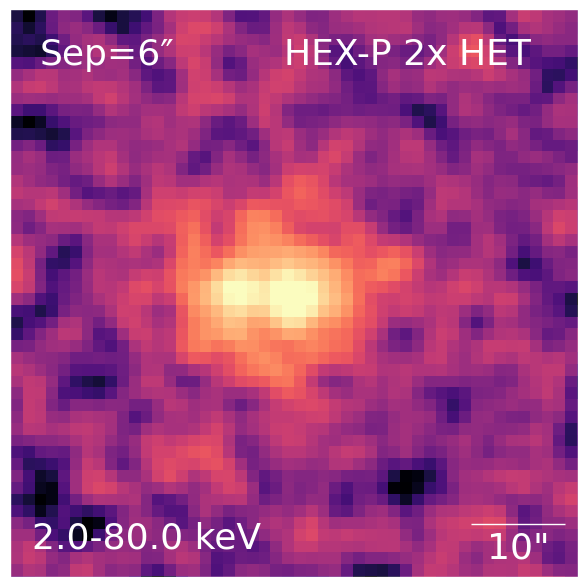

In [8]:
fig = plt.figure(figsize=(6,6))

#simxim('Borus/Sep_50as/IMAGE_50as_img50ks_2HETeff_NH1_22_NH2_22.fits', 50, "HEX-P HET", "2.0-100.0 keV", 2, 4, 1)
#simxim('Borus/Sep_40as/IMAGE_40as_img50ks_2HETeff_NH1_22_NH2_22.fits', 40, "HEX-P HET", "2.0-100.0 keV", 2, 4, 2)
#simxim('Borus/Sep_30as/IMAGE_30as_img50ks_2HETeff_NH1_22_NH2_22.fits', 30, "HEX-P HET", "2.0-100.0 keV", 2, 4, 3)
#simxim('Borus/Sep_20as/IMAGE_20as_img50ks_2HETeff_NH1_22_NH2_22.fits', 20, "HEX-P HET", "2.0-100.0 keV", 2, 4, 4)
#simxim('Borus/Sep_16as/IMAGE_16as_img50ks_2HETeff_NH1_22_NH2_22.fits', 16, "HEX-P HET", "2.0-100.0 keV", 2, 4, 5)
#simxim('Borus/Sep_10as/IMAGE_10as_img50ks_2HETeff_NH1_22_NH2_22.fits', 10, "HEX-P HET", "2.0-100.0 keV", 2, 4, 6)
simxim('Borus/Sep_6as/IMAGE_6as_img50ks_2HETeff_NH1_22_NH2_22.fits',   6, "HEX-P 2x HET", "2.0-80.0 keV", 1, 1, 1)
#simxim('Borus/Sep_0as/IMAGE_0as_img50ks_2HETeff_NH1_22_NH2_22.fits',   0, "HEX-P HET", "2.0-100.0 keV", 2, 4, 8)

plt.tight_layout()
#plt.savefig('HEX-P_hardxray_imaging_grid_smoothed.png', dpi=150)

plt.show()




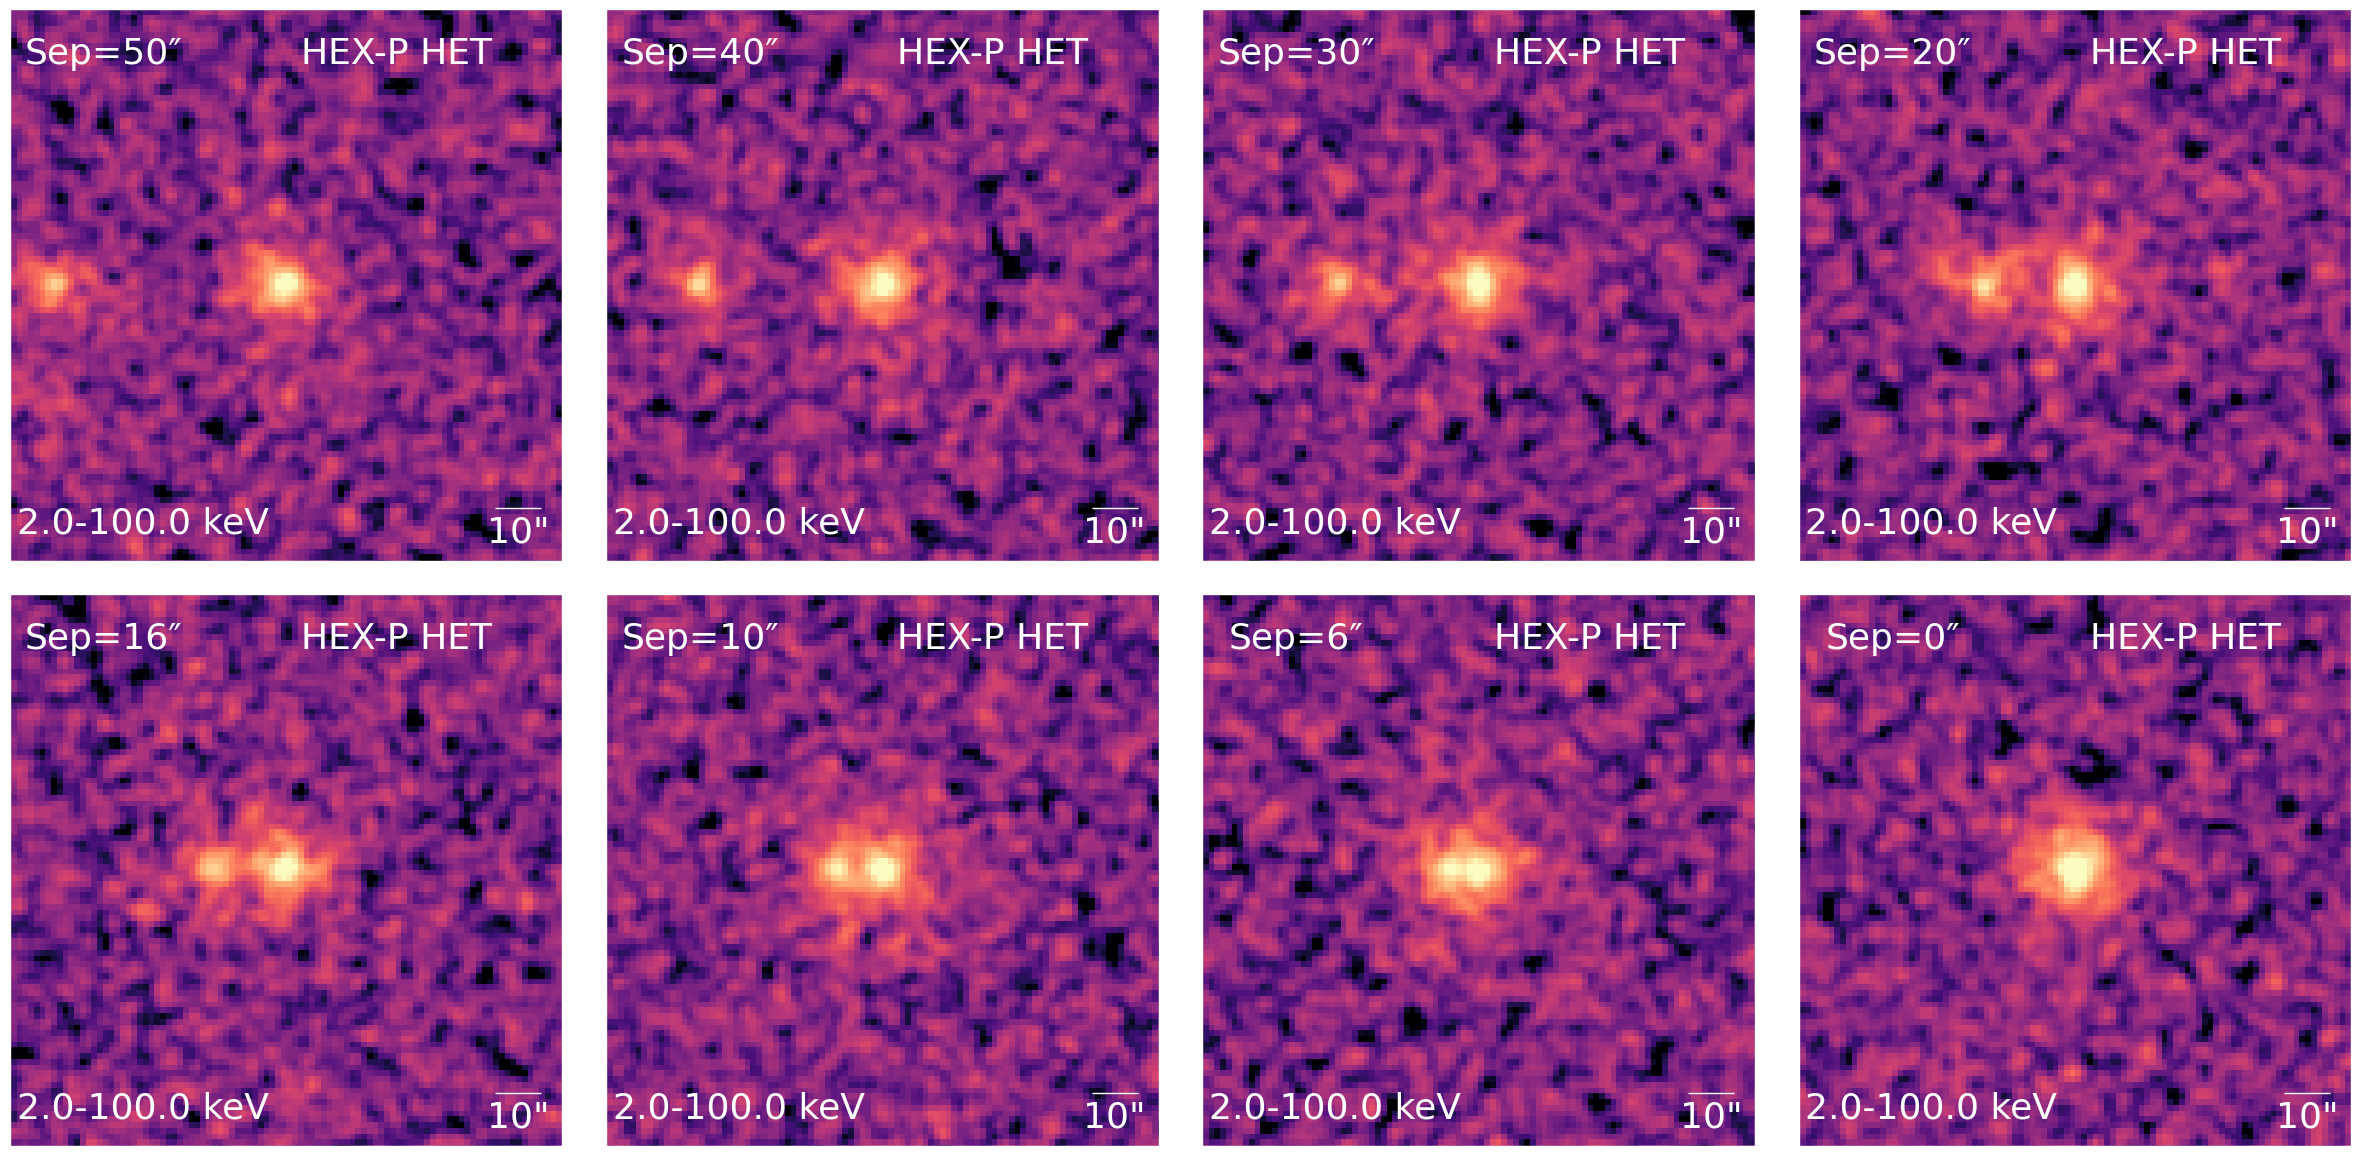

In [18]:
fig = plt.figure(figsize=(24,12))

simxim('Borus/Sep_50as/IMAGE_50as_img50ks_2HETeff_NH1_22_NH2_22.fits', 50, "HEX-P HET", "2.0-100.0 keV", 2, 4, 1)
simxim('Borus/Sep_40as/IMAGE_40as_img50ks_2HETeff_NH1_22_NH2_22.fits', 40, "HEX-P HET", "2.0-100.0 keV", 2, 4, 2)
simxim('Borus/Sep_30as/IMAGE_30as_img50ks_2HETeff_NH1_22_NH2_22.fits', 30, "HEX-P HET", "2.0-100.0 keV", 2, 4, 3)
simxim('Borus/Sep_20as/IMAGE_20as_img50ks_2HETeff_NH1_22_NH2_22.fits', 20, "HEX-P HET", "2.0-100.0 keV", 2, 4, 4)
simxim('Borus/Sep_16as/IMAGE_16as_img50ks_2HETeff_NH1_22_NH2_22.fits', 16, "HEX-P HET", "2.0-100.0 keV", 2, 4, 5)
simxim('Borus/Sep_10as/IMAGE_10as_img50ks_2HETeff_NH1_22_NH2_22.fits', 10, "HEX-P HET", "2.0-100.0 keV", 2, 4, 6)
simxim('Borus/Sep_6as/IMAGE_6as_img50ks_2HETeff_NH1_22_NH2_22.fits',   6, "HEX-P HET", "2.0-100.0 keV", 2, 4, 7)
simxim('Borus/Sep_0as/IMAGE_0as_img50ks_2HETeff_NH1_22_NH2_22.fits',   0, "HEX-P HET", "2.0-100.0 keV", 2, 4, 8)

plt.tight_layout()
#plt.savefig('HEX-P_hardxray_imaging_grid_smoothed.png', dpi=150)

plt.show()


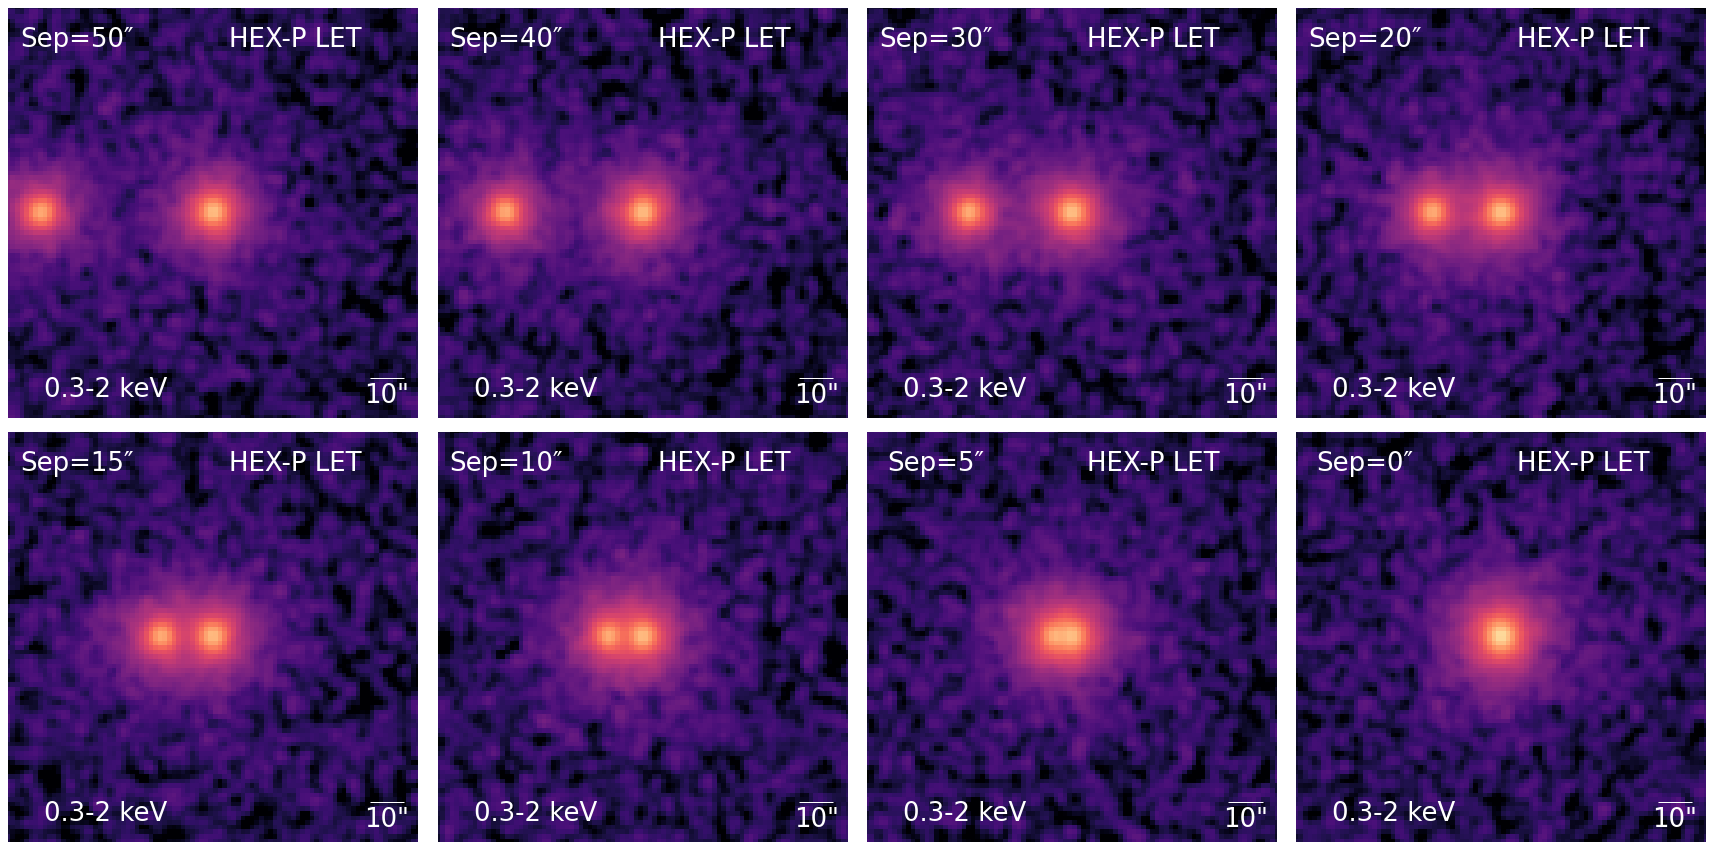

In [21]:
fig = plt.figure(figsize=(24,12))

simxim('Sep_50as/IMAGE_50as_img50ks_LET_NH1_22_NH2_22.fits', 50, "HEX-P LET", "0.3-2 keV", 2, 4, 1)
simxim('Sep_40as/IMAGE_40as_img50ks_LET_NH1_22_NH2_22.fits', 40, "HEX-P LET", "0.3-2 keV", 2, 4, 2)
simxim('Sep_30as/IMAGE_30as_img50ks_LET_NH1_22_NH2_22.fits', 30, "HEX-P LET", "0.3-2 keV", 2, 4, 3)
simxim('Sep_20as/IMAGE_20as_img50ks_LET_NH1_22_NH2_22.fits', 20, "HEX-P LET", "0.3-2 keV", 2, 4, 4)
simxim('Sep_15as/IMAGE_15as_img50ks_LET_NH1_22_NH2_22.fits', 15, "HEX-P LET", "0.3-2 keV", 2, 4, 5)
simxim('Sep_10as/IMAGE_10as_img50ks_LET_NH1_22_NH2_22.fits', 10, "HEX-P LET", "0.3-2 keV", 2, 4, 6)
simxim('Sep_5as/IMAGE_5as_img50ks_LET_NH1_22_NH2_22.fits',   5, "HEX-P LET", "0.3-2 keV", 2, 4, 7)
simxim('Sep_0as/IMAGE_0as_img50ks_LET_NH1_22_NH2_22.fits',   0, "HEX-P LET", "0.3-2 keV", 2, 4, 8)

plt.tight_layout()
plt.savefig('HEX-P_LETxray_imaging_grid_smoothed.png', dpi=150)

plt.show()



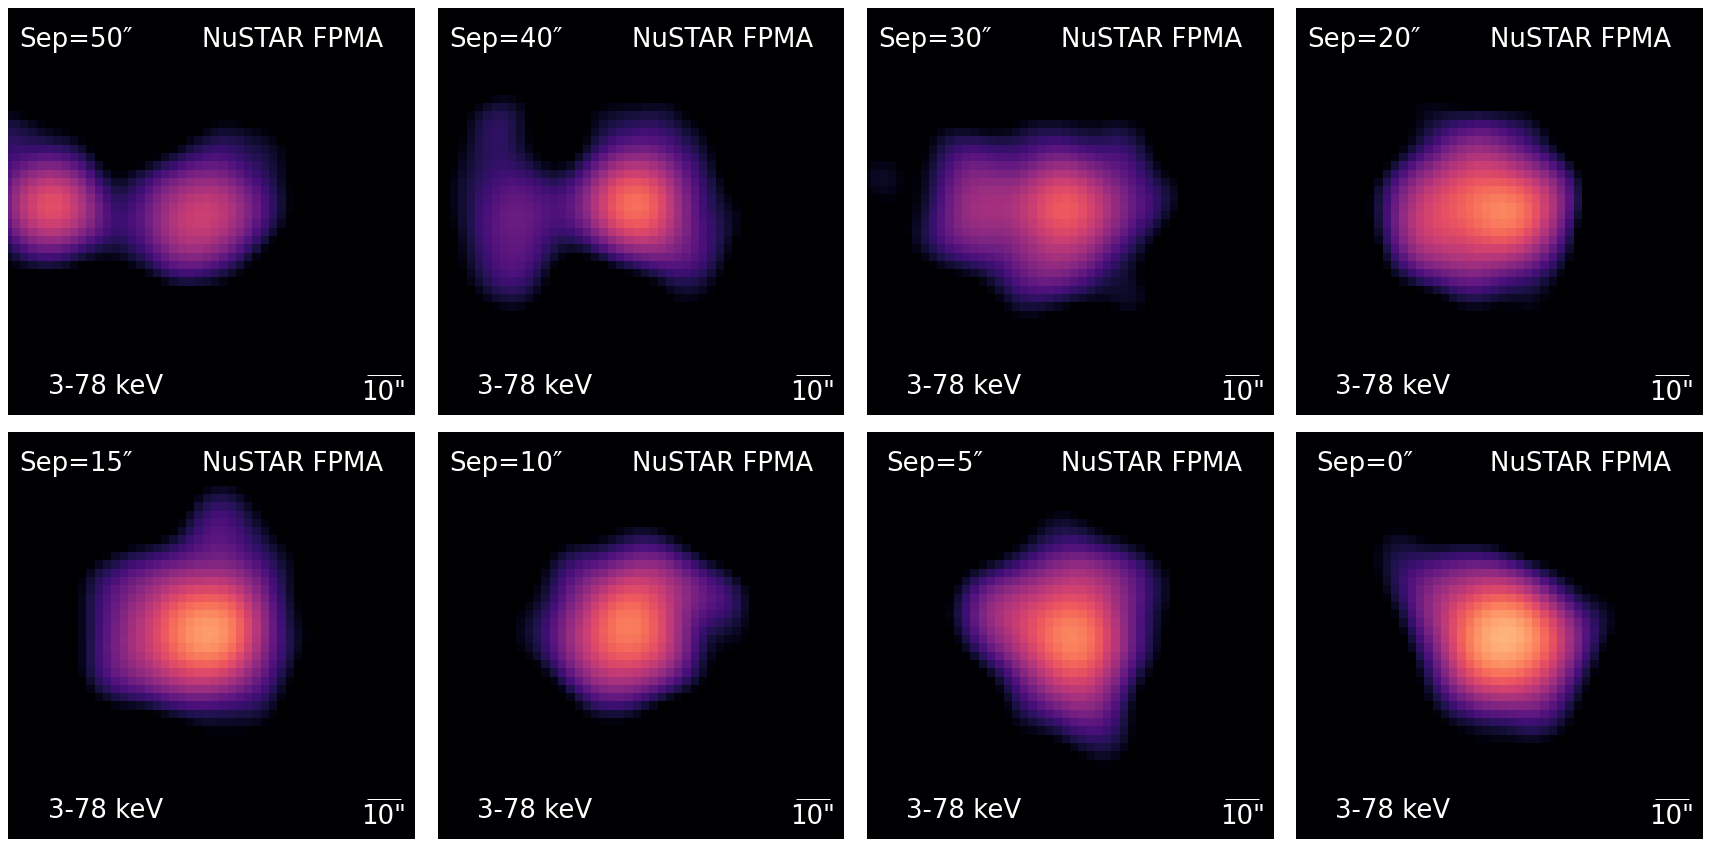

In [56]:
fig = plt.figure(figsize=(24,12))

simxim('Sep_50as/IMAGE_50as_img50ks_FPMA_NH1_22_NH2_22.fits', 50, "NuSTAR FPMA", "3-78 keV", 2, 4, 1)
simxim('Sep_40as/IMAGE_40as_img50ks_FPMA_NH1_22_NH2_22.fits', 40, "NuSTAR FPMA", "3-78 keV", 2, 4, 2)
simxim('Sep_30as/IMAGE_30as_img50ks_FPMA_NH1_22_NH2_22.fits', 30, "NuSTAR FPMA", "3-78 keV", 2, 4, 3)
simxim('Sep_20as/IMAGE_20as_img50ks_FPMA_NH1_22_NH2_22.fits', 20, "NuSTAR FPMA", "3-78 keV", 2, 4, 4)
simxim('Sep_15as/IMAGE_15as_img50ks_FPMA_NH1_22_NH2_22.fits', 15, "NuSTAR FPMA", "3-78 keV", 2, 4, 5)
simxim('Sep_10as/IMAGE_10as_img50ks_FPMA_NH1_22_NH2_22.fits', 10, "NuSTAR FPMA", "3-78 keV", 2, 4, 6)
simxim('Sep_5as/IMAGE_5as_img50ks_FPMA_NH1_22_NH2_22.fits',   5, "NuSTAR FPMA", "3-78 keV", 2, 4, 7)
simxim('Sep_0as/IMAGE_0as_img50ks_FPMA_NH1_22_NH2_22.fits',   0, "NuSTAR FPMA", "3-78 keV", 2, 4, 8)

plt.tight_layout()
plt.savefig('HEX-P_FPMAxray_imaging_grid_smoothed.png', dpi=150)

plt.show()




In [ ]:
# Finer grid being run down below here..... Deprecated as of 13 May 2023

In [57]:
os.chdir('Finer_sep_grid/')
os.getcwd()

'/Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid'

In [59]:
nhtor = [24] # torus column density
#nhlos = [1.e+22,1.e+23,1.e+24] # los of sight column density
z = 0.05 # redshifts
angle = 70

In [60]:
# Here we are establishing the models for the borus models
def model_borus(z,angle,emin,emax,norm):
    model = "tbabs*(atable{/Users/ryan/Dropbox/GitHub/SOXS/LEM/borus02_v170323c.fits}+ztbabs*cabs*zcutoffpl+const*zcutoffpl+apec+apec)" # A somewhat complicated model
    galnh = 1.0e-2
    emin = emin
    emax = emax
    nbins = 20000
    theta=angle
    flux = norm # erg/s/cm**2 # This is what we're rescaling the 2-10 keV band to, but we want this in the ~0.4-2 band which is ~2-10
    # I think actually 2-10 is --> 0.44-2.22
    #thetalist1 = []
    borus1 = []
    nh_tab1 = []
    #thetalist2 = []
    borus2 = []
    nh_tab2 = []
    for nh1 in nhtor:
        for nh2 in nhtor:
            #for i, j, k in zip(z2,vellista,z1):
            #for theta in angle:
            params = [galnh,1.8,300,nh1,60,theta,1.0,z,1.0e-3,((10**nh1)/(1.e+22)),z,((10**nh1)/(1.e+22)),1.8,300,z,1.e-3,0.005,1.8,300,z,1.e-3,0.1,1.0,z,1.e-3,0.90,1.0,z,1.e-3]    
            # For the 1st AGN
            spec1 = soxs.spectra.Spectrum.from_xspec_model(model, params, emin, emax, nbins)
            spec1.rescale_flux(1.e-13, emin=(2/(z+1)), emax=(10/(z+1)), flux_type="energy")
            borus1.append(spec1)
            nh_tab1.append(nh1)
            # For the 2nd AGN now:
            params = [galnh,1.8,300,nh2,60,theta,1.0,z,1.0e-3,((10**nh2)/(1.e+22)),z,((10**nh2)/(1.e+22)),1.8,300,z,1.e-3,0.005,1.8,300,z,1.e-3,0.3,1.0,z,1.e-3,0.65,1.0,z,1.e-3]    
            spec2 = soxs.spectra.Spectrum.from_xspec_model(model, params, emin, emax, nbins)
            spec2.rescale_flux(flux, emin=(2/(z+1)), emax=(10/(z+1)), flux_type="energy")
            borus2.append(spec2)
            nh_tab2.append(nh2)
    return borus1, nh_tab1, borus2, nh_tab2

# FLUXES OF 1.E-14 ARE TOO DIM!

In [61]:
borus1, nh_tab1, borus2, nh_tab2, = model_borus(z,angle,0.1,100.0,5.e-14)



In [65]:
from soxs import PointSourceModel
from soxs import write_spectrum
from soxs import plot_spectrum

# Center of the field of view
ra0 = 30.0 # degrees
dec0 = 45.0 # degrees

# Create a list of RA and Dec offsets that we'll load into a function to generate a series of point sources \
# at varying separations
c0 = SkyCoord(ra0*u.deg, dec0*u.deg, frame='icrs')
c1 = SkyCoord(ra0*u.deg, dec0*u.deg, frame='icrs') 

#sep=['50','40','30','20','18','16','14','12','10','8','6','4','2','0']
#ras1 = [c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra]
#decs1 = [c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec]

sep=['10','8','6','4','2','0']
ras1 = [c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra]
decs1 = [c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec]


ras2 = []
decs2 = []
for i in sep:
    c2 = c0.directional_offset_by(90 * u.deg, int(i) * u.arcsec) 
    ras2.append(c2.ra)
    decs2.append(c2.dec)

#print(ras2)
#print(decs2)

[<Longitude 30.00392837 deg>, <Longitude 30.0031427 deg>, <Longitude 30.00235702 deg>, <Longitude 30.00157135 deg>, <Longitude 30.00078567 deg>, <Longitude 30. deg>]
[<Latitude 44.99999993 deg>, <Latitude 44.99999996 deg>, <Latitude 44.99999998 deg>, <Latitude 44.99999999 deg>, <Latitude 45. deg>, <Latitude 45. deg>]


In [63]:
def sim_duals(ras1, decs1, ras2, decs2, sep, exp, borus1, nh_tab1, borus2, nh_tab2):
    for i,j,x,y,k in zip(ras1,decs1,ras2,decs2,sep):
        # Making directory for the particular separation in question
        if not os.path.exists('Sep_'+str(k)+'as/'):
            os.mkdir('Sep_'+str(k)+'as/')
        os.chdir('Sep_'+str(k)+'as/')
        print('Now working in directory: ' + os.getcwd())
        #Now creating the spatial models
        pt_src1 = PointSourceModel(i, j) # AGN1
        pt_src2 = PointSourceModel(x, y) # AGN2
        ###### Now generating source region apertures for the sources
        rad=10
        str1 = 'circle('+str(i/u.deg)+','+str(j/u.deg)+','+str(rad)+'''\"'''+')' #+'''\\''' + '\"' 
        str2 = 'circle('+str(x/u.deg)+','+str(y/u.deg)+','+str(rad)+'''\"'''+')' #+'''\\''' + '\"' 
        with open("cir1_"+str(k)+".reg", 'w') as reg1:
            reg1.write('# Region file format: DS9 version 4.1 \n')
            reg1.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            reg1.write('fk5 \n')
            reg1.write(str1) 
        with open("cir2_"+str(k)+".reg", 'w') as reg2:
            reg2.write('# Region file format: DS9 version 4.1 \n')
            reg2.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            reg2.write('fk5 \n')
            reg2.write(str2) 
        ##### Now generating a background region that we will compare to
        str3 = 'circle('+str(29.9916000)+','+str(45.0483000)+','+str(60)+'''\"'''+')' #+'''\\''' + '\"'
        with open("bkg_"+str(k)+".reg", 'w') as reg3:
            reg3.write('# Region file format: DS9 version 4.1 \n')
            reg3.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            reg3.write('fk5 \n')
            reg3.write(str3) 
        # Now adding a loop to generate simputs for the different combos of AGN1 and AGN2
        for spec1,spec2,nh1,nh2 in zip(borus1, borus2, nh_tab1, nh_tab2):
            # Generating the simput photon distributions convolved with a spatial model
            sou1_phlist = soxs.SimputPhotonList.from_models("AGN 1", spec1, pt_src1, (500.0, "ks"), (3.0, "m**2"))
            sou2_phlist = soxs.SimputPhotonList.from_models("AGN 2", spec2, pt_src2, (500.0, "ks"), (3.0, "m**2"))
            
            # Create the SIMPUT catalog "sim_cat" from the photon lists "AGN1" and "AGN2"
            NHflag="_NH1_"+str(nh1)+"_NH2_"+str(nh2)
            sim_cat = soxs.SimputCatalog.from_source("dualagn_"+str(k)+"as_simput"+str(NHflag)+".fits", sou1_phlist, overwrite=True)
            sim_cat.append(sou2_phlist)
            
            # Here we are interfacing with SIXTE with a bash script to generate event files, science images, and spectra
            #%run sixte_duals_simulations.sh sep ras1 decs1 exp # Running the sixte simulations now
            sim = subprocess.run('/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh '+ str(k) + ' ' + str(i/u.deg) + ' ' + str(j/u.deg) + ' ' + str(exp) + ' ' + str(NHflag), shell=True)
            print(sim)
            # This takes in arguments for the separation, ra1 and dec1, and the exposure time choice
            # These are needed for naming conventions, assignment of the observation pointing, and the exposure time
        os.chdir('../')



In [66]:
sim_duals(ras1, decs1, ras2, decs2, sep, 50000, borus1, nh_tab1, borus2, nh_tab2)



soxs : [INFO     ] 2023-03-17 17:45:50,347 Creating 20588708 energies from this spectrum.


Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid/Sep_10as


soxs : [INFO     ] 2023-03-17 17:45:53,411 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:45:55,499 Creating 15487356 energies from this spectrum.
soxs : [INFO     ] 2023-03-17 17:45:57,491 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:45:58,701 Appending source 'AGN 1' to dualagn_10as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-03-17 17:46:02,699 Appending source 'AGN 2' to dualagn_10as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_10as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_10as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_10as_evt50ks_HET1_NH1_24_NH2_24.fits' ...
start simulation ...
100 %
copy events to pattern file ...
start sky projection ...

cleaning up ...
finished successfully!

SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_10as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_10as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_10as_evt50ks_HET2_NH1

Parameter EvtFile: file "sixtesim_10as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_10as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_10as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_10as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 termin

cleaning up ...
CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 10 30.0 45.0 50000 _NH1_24_NH2_24', returncode=1)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid/Sep_8as


soxs : [INFO     ] 2023-03-17 17:48:59,702 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:49:01,276 Creating 15483534 energies from this spectrum.
soxs : [INFO     ] 2023-03-17 17:49:03,338 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:49:04,661 Appending source 'AGN 1' to dualagn_8as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-03-17 17:49:09,026 Appending source 'AGN 2' to dualagn_8as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_8as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_8as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_8as_evt50ks_HET1_NH1_24_NH2_24.fits' ...
start simulation ...
100 %
copy events to pattern file ...
start sky projection ...

cleaning up ...
finished successfully!

SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_8as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_8as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_8as_evt50ks_HET2_NH1_24_NH

Parameter EvtFile: file "sixtesim_8as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_8as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_8as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_8as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminatin

cleaning up ...
CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 8 30.0 45.0 50000 _NH1_24_NH2_24', returncode=1)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid/Sep_6as


soxs : [INFO     ] 2023-03-17 17:51:56,255 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:51:57,927 Creating 15487485 energies from this spectrum.
soxs : [INFO     ] 2023-03-17 17:51:59,971 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:52:01,252 Appending source 'AGN 1' to dualagn_6as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-03-17 17:52:05,595 Appending source 'AGN 2' to dualagn_6as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_6as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_6as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_6as_evt50ks_HET1_NH1_24_NH2_24.fits' ...
start simulation ...
100 %
copy events to pattern file ...
start sky projection ...

cleaning up ...
finished successfully!

SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_6as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_6as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_6as_evt50ks_HET2_NH1_24_NH

Parameter EvtFile: file "sixtesim_6as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_6as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_6as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_6as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminatin

initialize ...
open event file 'sixtesim_6as_evt50ks_2FPMeff_NH1_24_NH2_24.fits' ...
finished successfully!

cleaning up ...
cleaning up ...
cleaning up ...
cleaning up ...
CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 6 30.0 45.0 50000 _NH1_24_NH2_24', returncode=1)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid/Sep_4as


soxs : [INFO     ] 2023-03-17 17:54:52,235 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:54:54,323 Creating 15483545 energies from this spectrum.
soxs : [INFO     ] 2023-03-17 17:54:56,414 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:54:57,958 Appending source 'AGN 1' to dualagn_4as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-03-17 17:55:02,294 Appending source 'AGN 2' to dualagn_4as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_4as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_4as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_4as_evt50ks_HET1_NH1_24_NH2_24.fits' ...
start simulation ...
100 %
copy events to pattern file ...
start sky projection ...

cleaning up ...
finished successfully!

SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_4as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_4as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_4as_evt50ks_HET2_NH1_24_NH

Parameter EvtFile: file "sixtesim_4as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_4as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_4as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_4as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminatin

cleaning up ...
cleaning up ...
cleaning up ...
CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 4 30.0 45.0 50000 _NH1_24_NH2_24', returncode=1)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid/Sep_2as


soxs : [INFO     ] 2023-03-17 17:58:03,168 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:58:05,789 Creating 15489659 energies from this spectrum.
soxs : [INFO     ] 2023-03-17 17:58:07,933 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:58:09,423 Appending source 'AGN 1' to dualagn_2as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-03-17 17:58:13,758 Appending source 'AGN 2' to dualagn_2as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_2as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_2as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_2as_evt50ks_HET1_NH1_24_NH2_24.fits' ...
start simulation ...
100 %
copy events to pattern file ...
start sky projection ...

cleaning up ...
finished successfully!

SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_2as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_2as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_2as_evt50ks_HET2_NH1_24_NH

Parameter EvtFile: file "sixtesim_2as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_2as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_2as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_2as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminatin

cleaning up ...
cleaning up ...
CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 2 30.0 45.0 50000 _NH1_24_NH2_24', returncode=1)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid/Sep_0as


soxs : [INFO     ] 2023-03-17 18:01:17,959 Finished creating energies.
soxs : [INFO     ] 2023-03-17 18:01:20,104 Creating 15484490 energies from this spectrum.
soxs : [INFO     ] 2023-03-17 18:01:22,468 Finished creating energies.
soxs : [INFO     ] 2023-03-17 18:01:24,150 Appending source 'AGN 1' to dualagn_0as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-03-17 18:01:28,404 Appending source 'AGN 2' to dualagn_0as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_0as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_0as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_0as_evt50ks_HET1_NH1_24_NH2_24.fits' ...
start simulation ...
100 %
copy events to pattern file ...
start sky projection ...

cleaning up ...
finished successfully!

SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_0as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_0as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_0as_evt50ks_HET2_NH1_24_NH

Parameter EvtFile: file "sixtesim_0as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_0as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_0as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_0as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminatin

In [ ]:
# Deprecated down here



In [ ]:
## Here we are establishing the models for the borus models
#def model_borus(z,angle,emin,emax,norm):
#    model = "tbabs*(atable{/Users/ryan/Dropbox/GitHub/SOXS/LEM/borus02_v170323c.fits}+ztbabs*cabs*zcutoffpl+const*zcutoffpl)" # A somewhat complicated model
#    #+apec+apec
#    z=z
#    galnh = 1.0e-2
#    emin = emin
#    emax = emax
#    nbins = 20000
#    theta=angle
#    flux = norm # erg/s/cm**2 # This is what we're rescaling the 2-10 keV band to, but we want this in the ~0.4-2 band which is ~2-10
#    # I think actually 2-10 is --> 0.44-2.22
#    #thetalist1 = []
#    borus1 = []
#    nhtor_tab1 = []
#    nhlos_tab1 = []
#    #thetalist2 = []
#    borus2 = []
#    nhtor_tab2 = []
#    nhlos_tab2 = []
#    for nh1,nh2 in zip(nhtor,nhlos):
#        #for nh2 in nhlos:
#        #for i, j, k in zip(z2,vellista,z1):
#        #for theta in angle:
#        params = [galnh,1.8,300,24,60,70,1.0,z,1.0e-3,1.e+22/(1.e+22),z,1.e+22/(1.e+22),1.8,300,z,1.e-3,0.005,1.8,300,z,1.e-3]    
#        # For the 1st AGN
#        spec1 = soxs.spectra.Spectrum.from_xspec_model(model, params, emin, emax, nbins)
#        spec1.rescale_flux(1.e-14, emin=(2/(z+1)), emax=(10/(z+1)), flux_type="energy")
#        borus1.append(spec1)
#        nhtor_tab1.append(1.e+24)
#        nhlos_tab1.append(1.e+24)
#        #thetalist1.append(70)
#    # For the 2nd AGN now:
#    for nh1,nh2 in zip(nhtor,nhlos):
#        params = [galnh,1.8,300,nh1,60,theta,1.0,i,1.0e-3,nh2/(1.e+22),z,nh2/(1.e+22),1.8,300,z,1.e-3,0.005,1.8,300,z,1.e-3]    
#        spec2 = soxs.spectra.Spectrum.from_xspec_model(model, params, emin, emax, nbins)
#        spec2.rescale_flux(flux, emin=(2/(z+1)), emax=(10/(z+1)), flux_type="energy")
#        borus2.append(spec2)
#        nhtor_tab2.append(nh1)
#        nhlos_tab2.append(nh2)
#        #thetalist2.append(theta)
#    return borus1, nhtor_tab1, nhlos_tab1, borus2, nhtor_tab2, nhlos_tab2
#

